# 02 - Preprocesamiento de Datos para Detección de Fraude

## 🎯 Objetivos de este Notebook

En este notebook aprenderás y aplicarás técnicas fundamentales de preprocesamiento:

1. **Escalado de variables**: Normalizar los datos para que tengan la misma escala
2. **División de datos**: Separar en conjuntos de entrenamiento, validación y prueba
3. **Balanceo de clases**: Resolver el problema de clases desbalanceadas con SMOTE
4. **Pipeline de preprocesamiento**: Encadenar transformaciones de forma reproducible

## 📊 Dataset: Credit Card Fraud Detection
- **Problema**: Clasificación binaria (Fraude vs No Fraude)
- **Desafío**: Dataset altamente desbalanceado (~0.17% de fraudes)

In [21]:
# Importaciones estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn para preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# SMOTE para balanceo de clases
from imblearn.over_sampling import SMOTE

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [22]:
# Definir rutas del proyecto
PROJECT_ROOT = Path.cwd().parent  # Subir un nivel desde notebooks/
DATA_PATH = PROJECT_ROOT / 'data'
RAW_DATA_PATH = DATA_PATH / 'raw'
PROCESSED_DATA_PATH = DATA_PATH / 'processed'

# Crear directorio processed si no existe
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)

print(f"📁 Directorio del proyecto: {PROJECT_ROOT}")
print(f"📁 Datos procesados se guardarán en: {PROCESSED_DATA_PATH}")

📁 Directorio del proyecto: c:\dev\repos-deep-learning\fraude-detection
📁 Datos procesados se guardarán en: c:\dev\repos-deep-learning\fraude-detection\data\processed


In [23]:
# Cargar el dataset
df = pd.read_csv(RAW_DATA_PATH / 'creditcard.csv')

print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"📊 Columnas: {df.columns.tolist()}")
print(f"\n🔍 Primeras filas:")
df.head()

📊 Dimensiones del dataset: (284807, 31)
📊 Columnas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

🔍 Primeras filas:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
# Información básica del dataset
print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)

print(f"\n📊 Total de transacciones: {len(df):,}")
print(f"📊 Total de variables: {df.shape[1]}")

# Distribución de la variable objetivo
print(f"\n🎯 Distribución de la clase objetivo:")
print(df['Class'].value_counts())
print(f"\n📈 Porcentaje de fraudes: {df['Class'].mean() * 100:.3f}%")

# Verificar valores nulos
print(f"\n❓ Valores nulos por columna:")
print(df.isnull().sum().sum(), "valores nulos en total")

INFORMACIÓN DEL DATASET

📊 Total de transacciones: 284,807
📊 Total de variables: 31

🎯 Distribución de la clase objetivo:
Class
0    284315
1       492
Name: count, dtype: int64

📈 Porcentaje de fraudes: 0.173%

❓ Valores nulos por columna:
0 valores nulos en total


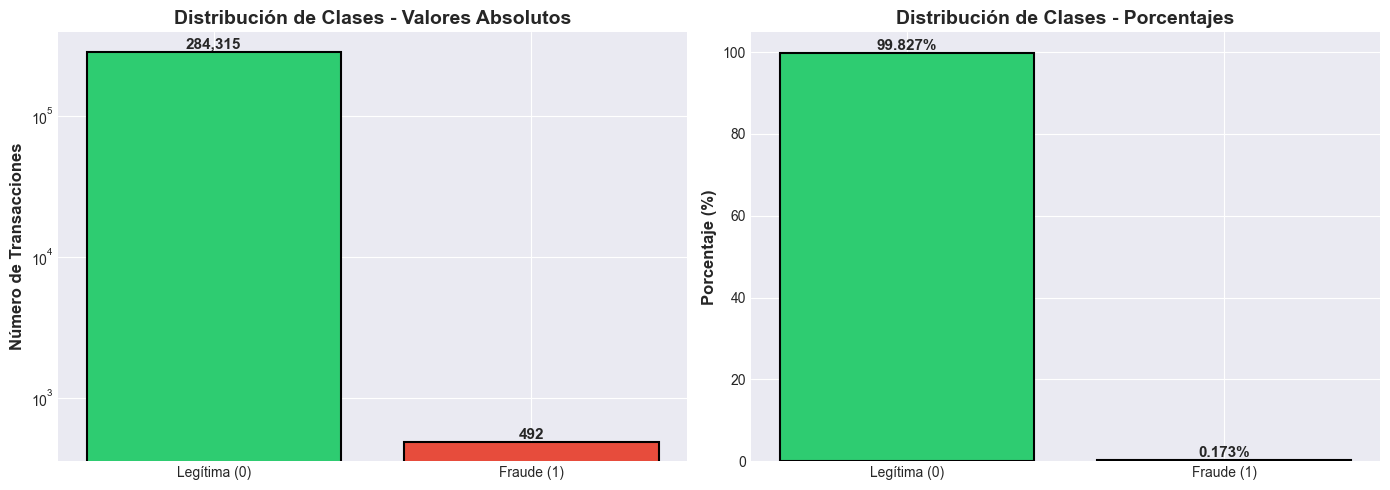


⚠️ DESBALANCEO EXTREMO:
   Por cada transacción fraudulenta, hay 578 transacciones legítimas
   Ratio: 1:578


In [25]:
# Visualizar el desbalanceo de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Conteo absoluto
class_counts = df['Class'].value_counts()
axes[0].bar(['Legítima (0)', 'Fraude (1)'], class_counts.values, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Número de Transacciones', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Clases - Valores Absolutos', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')  # Escala logarítmica para visualizar mejor

# Añadir etiquetas
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gráfico 2: Porcentajes
class_percentages = df['Class'].value_counts(normalize=True) * 100
axes[1].bar(['Legítima (0)', 'Fraude (1)'], class_percentages.values,
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Clases - Porcentajes', fontsize=14, fontweight='bold')

# Añadir etiquetas
for i, v in enumerate(class_percentages.values):
    axes[1].text(i, v, f'{v:.3f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcular el ratio de desbalanceo
ratio = class_counts[0] / class_counts[1]
print(f"\n⚠️ DESBALANCEO EXTREMO:")
print(f"   Por cada transacción fraudulenta, hay {ratio:.0f} transacciones legítimas")
print(f"   Ratio: 1:{ratio:.0f}")

## 🔧 ESCALADO DE CARACTERÍSTICAS (Feature Scaling)

### ¿Por qué necesitamos escalar?

Los algoritmos de Machine Learning funcionan mejor cuando todas las variables están en **escalas similares**.

#### 📊 Ejemplo del problema:

Imagina estas dos variables en nuestro dataset:
- **Time**: Valores entre 0 y 172,792 (segundos)
- **Amount**: Valores entre 0 y 25,691 (dólares)

Si no escalamos:
- El modelo podría dar **más importancia** a `Time` solo porque sus valores son más grandes
- Algoritmos como Regresión Logística y SVM son **muy sensibles** a la escala

---

### 🎯 StandardScaler (Estandarización)

**Fórmula**: z = (x - μ) / σ

Donde:
- `x` = valor original
- `μ` = media de la variable
- `σ` = desviación estándar

**Resultado**:
- Media (μ) = 0
- Desviación estándar (σ) = 1
- Los valores quedan centrados alrededor de 0

---

### 🔍 ¿Cuándo usar StandardScaler?

✅ **Úsalo cuando:**
- Los datos siguen una distribución aproximadamente normal
- Usas algoritmos basados en distancias (KNN, SVM)
- Usas Regresión Logística o Redes Neuronales

❌ **NO lo uses con:**
- Árboles de decisión y Random Forest (son invariantes a la escala)
- En nuestro caso: Las variables V1-V28 ya están escaladas (son resultado de PCA)

In [26]:
# Analizar las variables ANTES de escalar
print("=" * 60)
print("ESTADÍSTICAS ANTES DEL ESCALADO")
print("=" * 60)

variables_to_scale = ['Time', 'Amount']

for var in variables_to_scale:
    print(f"\n📊 Variable: {var}")
    print(f"   • Mínimo:  {df[var].min():.2f}")
    print(f"   • Máximo:  {df[var].max():.2f}")
    print(f"   • Media:   {df[var].mean():.2f}")
    print(f"   • Mediana: {df[var].median():.2f}")
    print(f"   • Desv. Estándar: {df[var].std():.2f}")

ESTADÍSTICAS ANTES DEL ESCALADO

📊 Variable: Time
   • Mínimo:  0.00
   • Máximo:  172792.00
   • Media:   94813.86
   • Mediana: 84692.00
   • Desv. Estándar: 47488.15

📊 Variable: Amount
   • Mínimo:  0.00
   • Máximo:  25691.16
   • Media:   88.35
   • Mediana: 22.00
   • Desv. Estándar: 250.12


In [27]:
# Crear una copia del dataframe para no modificar el original
df_scaled = df.copy()

# Inicializar el scaler
scaler = StandardScaler()

# Escalar Time y Amount
df_scaled[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

print("✅ Escalado aplicado correctamente")
print("\n" + "=" * 60)
print("ESTADÍSTICAS DESPUÉS DEL ESCALADO")
print("=" * 60)

for var in variables_to_scale:
    print(f"\n📊 Variable: {var}")
    print(f"   • Mínimo:  {df_scaled[var].min():.4f}")
    print(f"   • Máximo:  {df_scaled[var].max():.4f}")
    print(f"   • Media:   {df_scaled[var].mean():.6f}")  # Debería ser ~0
    print(f"   • Mediana: {df_scaled[var].median():.4f}")
    print(f"   • Desv. Estándar: {df_scaled[var].std():.6f}")  # Debería ser ~1

✅ Escalado aplicado correctamente

ESTADÍSTICAS DESPUÉS DEL ESCALADO

📊 Variable: Time
   • Mínimo:  -1.9966
   • Máximo:  1.6421
   • Media:   -0.000000
   • Mediana: -0.2131
   • Desv. Estándar: 1.000002

📊 Variable: Amount
   • Mínimo:  -0.3532
   • Máximo:  102.3622
   • Media:   -0.000000
   • Mediana: -0.2653
   • Desv. Estándar: 1.000002


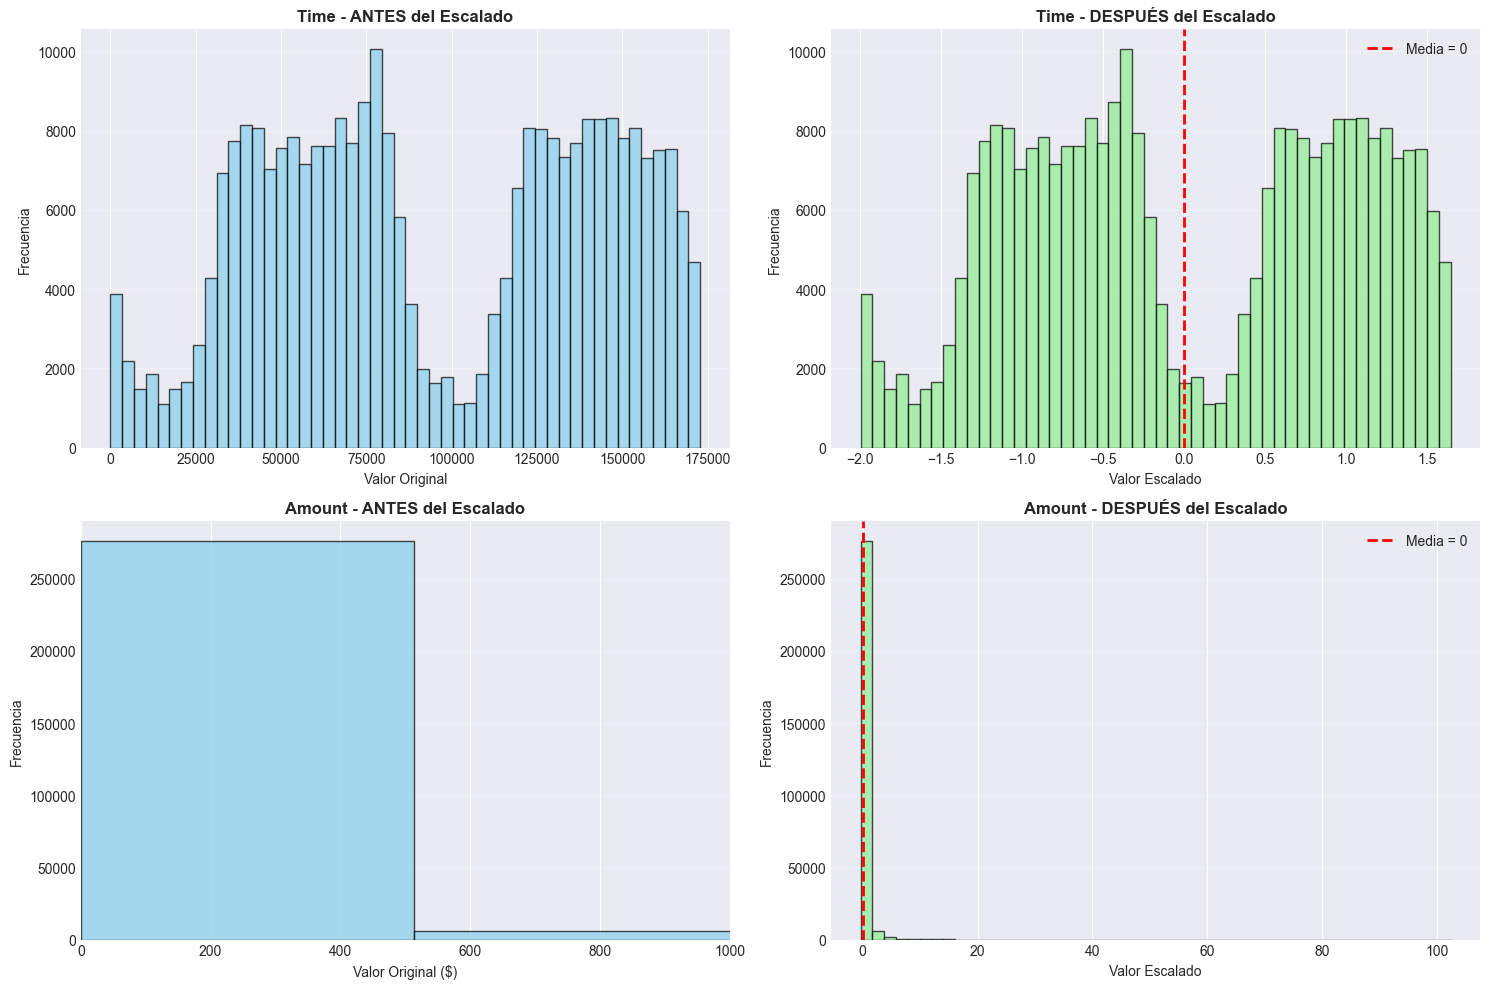

✅ Observa cómo ambas variables ahora están centradas en 0


In [28]:
# Comparar distribuciones antes y después del escalado
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time - ANTES
axes[0, 0].hist(df['Time'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Time - ANTES del Escalado', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Valor Original')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(axis='y', alpha=0.3)

# Time - DESPUÉS
axes[0, 1].hist(df_scaled['Time'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Time - DESPUÉS del Escalado', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Valor Escalado')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Media = 0')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Amount - ANTES
axes[1, 0].hist(df['Amount'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Amount - ANTES del Escalado', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Valor Original ($)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_xlim([0, 1000])  # Limitar para mejor visualización
axes[1, 0].grid(axis='y', alpha=0.3)

# Amount - DESPUÉS
axes[1, 1].hist(df_scaled['Amount'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Amount - DESPUÉS del Escalado', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Valor Escalado')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Media = 0')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Observa cómo ambas variables ahora están centradas en 0")

## 📊 DIVISIÓN DE DATOS: Train / Validation / Test

### ¿Por qué dividir los datos?

Imagina que estudias para un examen **memorizando** las respuestas exactas. 
- En el mismo examen: 100% ✅
- En un examen diferente: ¿? ❌

**En Machine Learning pasa lo mismo:**
- Si evaluamos el modelo con los mismos datos que usó para aprender, obtenemos resultados engañosos
- Necesitamos datos "nuevos" que el modelo nunca haya visto

---

Dataset Completo (100%)
│
├─── **TRAIN (64%)**        → Para entrenar el modelo (`X_train`, `y_train`)
├─── **VALIDATION (16%)**   → Para ajustar hiperparámetros (`X_val`, `y_val`)
└─── **TEST (20%)**         → Para evaluación final (`X_test`, `y_test`)
#### 1️⃣ **TRAIN SET (Entrenamiento)**
- El modelo **aprende** de estos datos
- Es el conjunto más grande (~64%)
- Aquí es donde aplicaremos SMOTE para balancear clases

#### 2️⃣ **VALIDATION SET (Validación)**
- Para **comparar modelos** y ajustar parámetros
- El modelo NO entrena con estos datos
- (~16% del total)
- Nos ayuda a evitar overfitting

#### 3️⃣ **TEST SET (Prueba)**
- **Evaluación final** del modelo
- Solo se usa UNA vez, al final del proyecto
- (~20% del total)
- Simula datos "del mundo real"

---

### ⚠️ REGLA DE ORO

**NUNCA uses el Test Set hasta el final del proyecto**

Si lo usas durante el desarrollo, estarías "filtrando información" y tus resultados finales serían optimistas.

---

### 🔄 Estratificación (Stratified Split)

Con clases desbalanceadas, debemos usar **estratificación**:
- Mantiene la misma proporción de fraudes en train, validation y test
- Si el dataset tiene 0.17% fraudes, cada conjunto tendrá ~0.17% fraudes

**Sin estratificación**: Podrías terminar con muy pocos (o cero) fraudes en algún conjunto ❌
**Con estratificación**: Todas las divisiones mantienen la proporción original ✅

In [29]:
# Separar Features (X) y Target (y)
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

print("=" * 60)
print("SEPARACIÓN DE FEATURES Y TARGET")
print("=" * 60)
print(f"\n📊 X (Features): {X.shape}")
print(f"📊 y (Target): {y.shape}")
print(f"\n✅ Features (X): {X.columns.tolist()[:5]}... (30 columnas)")
print(f"✅ Target (y): Class [0 = Legítima, 1 = Fraude]")

SEPARACIÓN DE FEATURES Y TARGET

📊 X (Features): (284807, 30)
📊 y (Target): (284807,)

✅ Features (X): ['Time', 'V1', 'V2', 'V3', 'V4']... (30 columnas)
✅ Target (y): Class [0 = Legítima, 1 = Fraude]


In [30]:
# Primera división: (Train + Validation) vs Test
# 80% para Train+Val, 20% para Test
TEST_SIZE = 0.2

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y  # ← ESTRATIFICACIÓN: mantener proporción de clases
)

print("=" * 60)
print("PRIMERA DIVISIÓN: (TRAIN+VAL) vs TEST")
print("=" * 60)

print(f"\n1️⃣ Train + Validation (temporal):")
print(f"   • X_temp: {X_temp.shape}")
print(f"   • y_temp: {y_temp.shape}")
print(f"   • Porcentaje: {len(X_temp) / len(X) * 100:.1f}%")

print(f"\n2️⃣ Test Set:")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_test: {y_test.shape}")
print(f"   • Porcentaje: {len(X_test) / len(X) * 100:.1f}%")

# Verificar estratificación
print(f"\n✅ Verificación de Estratificación:")
print(f"   Dataset original:  {y.mean() * 100:.3f}% fraudes")
print(f"   Train+Val:         {y_temp.mean() * 100:.3f}% fraudes")
print(f"   Test:              {y_test.mean() * 100:.3f}% fraudes")
print(f"\n   → Las proporciones se mantienen ✅")

PRIMERA DIVISIÓN: (TRAIN+VAL) vs TEST

1️⃣ Train + Validation (temporal):
   • X_temp: (227845, 30)
   • y_temp: (227845,)
   • Porcentaje: 80.0%

2️⃣ Test Set:
   • X_test: (56962, 30)
   • y_test: (56962,)
   • Porcentaje: 20.0%

✅ Verificación de Estratificación:
   Dataset original:  0.173% fraudes
   Train+Val:         0.173% fraudes
   Test:              0.172% fraudes

   → Las proporciones se mantienen ✅


In [31]:
# Segunda división: Train vs Validation
# Del 80% restante: 80% para Train, 20% para Validation
# Esto da: 64% Train, 16% Validation, 20% Test
VALIDATION_SIZE = 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("=" * 60)
print("SEGUNDA DIVISIÓN: TRAIN vs VALIDATION")
print("=" * 60)

print(f"\n1️⃣ TRAIN SET:")
print(f"   • X_train: {X_train.shape}")
print(f"   • y_train: {y_train.shape}")
print(f"   • Porcentaje del total: {len(X_train) / len(X) * 100:.1f}%")
print(f"   • Legítimas: {(y_train == 0).sum():,}")
print(f"   • Fraudes:   {(y_train == 1).sum():,}")

print(f"\n2️⃣ VALIDATION SET:")
print(f"   • X_val: {X_val.shape}")
print(f"   • y_val: {y_val.shape}")
print(f"   • Porcentaje del total: {len(X_val) / len(X) * 100:.1f}%")
print(f"   • Legítimas: {(y_val == 0).sum():,}")
print(f"   • Fraudes:   {(y_val == 1).sum():,}")

print(f"\n3️⃣ TEST SET:")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_test: {y_test.shape}")
print(f"   • Porcentaje del total: {len(X_test) / len(X) * 100:.1f}%")
print(f"   • Legítimas: {(y_test == 0).sum():,}")
print(f"   • Fraudes:   {(y_test == 1).sum():,}")

# Visualizar la división
print("\n" + "=" * 60)
print("RESUMEN VISUAL DE LA DIVISIÓN")
print("=" * 60)

total = len(X)
train_pct = len(X_train) / total * 100
val_pct = len(X_val) / total * 100
test_pct = len(X_test) / total * 100

print(f"\n📊 Dataset Completo: {total:,} transacciones")
print(f"   ├── Train:      {len(X_train):,} ({train_pct:.1f}%) ✅")
print(f"   ├── Validation: {len(X_val):,} ({val_pct:.1f}%) 🔧")
print(f"   └── Test:       {len(X_test):,} ({test_pct:.1f}%) 🧪")

SEGUNDA DIVISIÓN: TRAIN vs VALIDATION

1️⃣ TRAIN SET:
   • X_train: (182276, 30)
   • y_train: (182276,)
   • Porcentaje del total: 64.0%
   • Legítimas: 181,961
   • Fraudes:   315

2️⃣ VALIDATION SET:
   • X_val: (45569, 30)
   • y_val: (45569,)
   • Porcentaje del total: 16.0%
   • Legítimas: 45,490
   • Fraudes:   79

3️⃣ TEST SET:
   • X_test: (56962, 30)
   • y_test: (56962,)
   • Porcentaje del total: 20.0%
   • Legítimas: 56,864
   • Fraudes:   98

RESUMEN VISUAL DE LA DIVISIÓN

📊 Dataset Completo: 284,807 transacciones
   ├── Train:      182,276 (64.0%) ✅
   ├── Validation: 45,569 (16.0%) 🔧
   └── Test:       56,962 (20.0%) 🧪


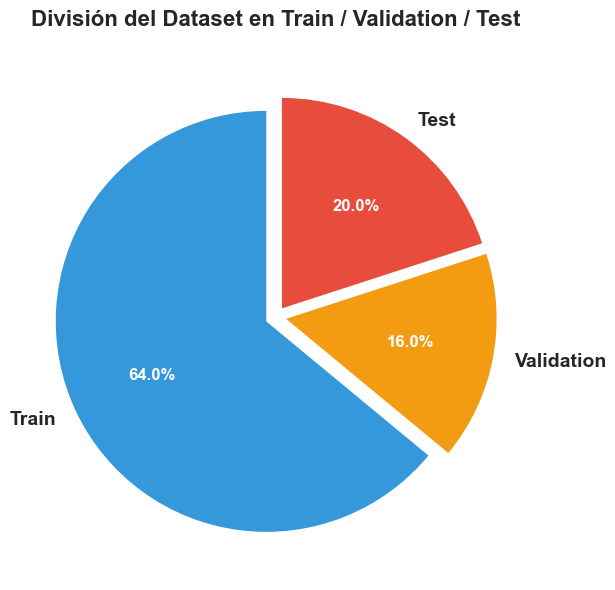

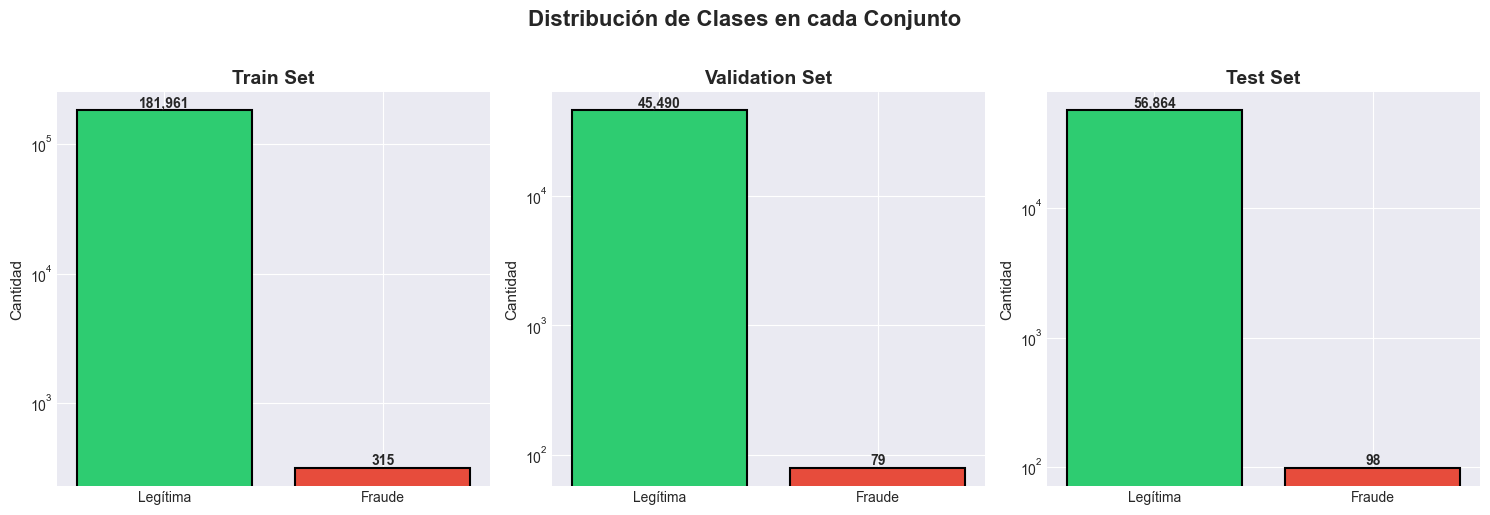

✅ Como puedes ver, la proporción de fraudes se mantiene similar en los 3 conjuntos


In [32]:
# Gráfico de la división de datos
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sets = ['Train', 'Validation', 'Test']
sizes = [len(X_train), len(X_val), len(X_test)]
colors = ['#3498db', '#f39c12', '#e74c3c']
explode = (0.05, 0.05, 0.05)

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=sets,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    textprops={'fontsize': 14, 'fontweight': 'bold'}
)

# Mejorar el estilo
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

ax.set_title('División del Dataset en Train / Validation / Test', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Mostrar distribución de fraudes en cada conjunto
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, (X_set, y_set, name) in enumerate([
    (X_train, y_train, 'Train'),
    (X_val, y_val, 'Validation'),
    (X_test, y_test, 'Test')
]):
    counts = y_set.value_counts()
    ax[i].bar(['Legítima', 'Fraude'], counts.values, 
              color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
    ax[i].set_title(f'{name} Set', fontsize=14, fontweight='bold')
    ax[i].set_ylabel('Cantidad', fontsize=11)
    ax[i].set_yscale('log')
    
    # Añadir valores
    for j, v in enumerate(counts.values):
        ax[i].text(j, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Distribución de Clases en cada Conjunto', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Como puedes ver, la proporción de fraudes se mantiene similar en los 3 conjuntos")

## ⚖️ SMOTE: Balanceo de Clases

### 🤔 El Problema de las Clases Desbalanceadas

Actualmente tenemos:
- **Train Set**: ~99.83% transacciones legítimas, ~0.17% fraudes
- El modelo podría aprender: "predice siempre 0 (legítima)" → 99.83% accuracy ❌
- Pero esto sería **inútil**: ¡No detectaríamos ningún fraude!

---

### 💡 Soluciones Posibles

#### ❌ Solución Ingenua: Duplicar los fraudes
```python
# MAL: Simplemente copiar filas
fraud_rows = df[df['Class'] == 1]
df_balanced = pd.concat([df, fraud_rows, fraud_rows, fraud_rows])
```
A (fraude real)
    |
    |  ← nuevo fraude sintético (interpolación)
    |
B (fraude real)
Fórmula matemática:
nuevo_punto = A + λ × (B - A)
Donde λ es un número aleatorio entre 0 y 1

📊 Ejemplo Visual
Imagina que tienes fraudes con estas características:
Fraude 1: [Time=5000, Amount=100, V1=2.5]
Fraude 2: [Time=6000, Amount=150, V1=3.0]
Fraude Sintético: [Time=5500, Amount=125, V1=2.75]

SMOTE genera (con λ=0.5):
Fraude Sintético: [Time=5500, Amount=125, V1=2.75]
Es una interpolación, no una copia exacta ✅

```python
SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
```
sampling_strategy: Ratio deseado minority/majority

0.5 = queremos que fraudes sean el 50% de legítimas
1.0 = queremos exactamente el mismo número


k_neighbors: Número de vecinos para interpolar (default=5)
random_state: Semilla para reproducibilidad

## ⚠️ IMPORTANTE: ¿Dónde aplicar SMOTE?
✅ CORRECTO:
   1. Dividir datos → Train / Val / Test
   2. Aplicar SMOTE SOLO en Train
   3. Entrenar modelo
   4. Evaluar en Val y Test (SIN SMOTE)

❌ INCORRECTO:
   1. Aplicar SMOTE en TODO el dataset
   2. Dividir datos
   ⚠️ Filtración de información: El test tendría datos sintéticos

### Regla de oro:

SMOTE solo en TRAIN
Validation y Test deben ser datos reales

🎯 ¿Cuándo usar SMOTE?
✅ Úsalo cuando:

Tienes clases muy desbalanceadas (<5% minoritaria)
La clase minoritaria es importante (fraudes, enfermedades)
Tienes suficientes ejemplos de la minoritaria (>100)

❌ NO lo uses cuando:

Las clases están balanceadas
Tienes MUY pocos ejemplos (<50) de la minoritaria
Usas modelos como XGBoost (tienen su propio manejo de desbalanceo)


In [33]:
# Analizar el desbalanceo en el Train Set ANTES de SMOTE
print("=" * 60)
print("ANÁLISIS DEL TRAIN SET - ANTES DE SMOTE")
print("=" * 60)

# Conteo de clases
train_counts = y_train.value_counts()
train_percentages = y_train.value_counts(normalize=True) * 100

print(f"\n📊 Distribución actual:")
print(f"   • Legítimas (0): {train_counts[0]:,} ({train_percentages[0]:.3f}%)")
print(f"   • Fraudes (1):   {train_counts[1]:,} ({train_percentages[1]:.3f}%)")

# Calcular ratio
ratio_before = train_counts[0] / train_counts[1]
print(f"\n⚖️ Ratio de desbalanceo: 1:{ratio_before:.0f}")
print(f"   (Por cada fraude, hay {ratio_before:.0f} transacciones legítimas)")

print(f"\n⚠️ PROBLEMA:")
print(f"   Si el modelo predice siempre 'Legítima', tendría {train_percentages[0]:.2f}% accuracy")
print(f"   ¡Pero NO detectaría ningún fraude! ❌")

ANÁLISIS DEL TRAIN SET - ANTES DE SMOTE

📊 Distribución actual:
   • Legítimas (0): 181,961 (99.827%)
   • Fraudes (1):   315 (0.173%)

⚖️ Ratio de desbalanceo: 1:578
   (Por cada fraude, hay 578 transacciones legítimas)

⚠️ PROBLEMA:
   Si el modelo predice siempre 'Legítima', tendría 99.83% accuracy
   ¡Pero NO detectaría ningún fraude! ❌


In [34]:
# Configurar SMOTE
# sampling_strategy=0.5 significa que queremos que los fraudes sean el 50% de las legítimas
# Ejemplo: Si tenemos 10,000 legítimas, queremos 5,000 fraudes
SAMPLING_STRATEGY = 0.5

print("=" * 60)
print("APLICANDO SMOTE")
print("=" * 60)

print(f"\n⚙️ Configuración:")
print(f"   • sampling_strategy: {SAMPLING_STRATEGY}")
print(f"   • k_neighbors: 5 (default)")
print(f"   • random_state: {RANDOM_STATE}")

# Crear instancia de SMOTE
smote = SMOTE(
    sampling_strategy=SAMPLING_STRATEGY,
    random_state=RANDOM_STATE,
    k_neighbors=5
)

# Aplicar SMOTE solo en el Train Set
print(f"\n⏳ Generando ejemplos sintéticos...")
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"✅ SMOTE aplicado correctamente")

# Análisis POST-SMOTE
print("\n" + "=" * 60)
print("ANÁLISIS DEL TRAIN SET - DESPUÉS DE SMOTE")
print("=" * 60)

balanced_counts = pd.Series(y_train_balanced).value_counts()
balanced_percentages = pd.Series(y_train_balanced).value_counts(normalize=True) * 100

print(f"\n📊 Distribución después de SMOTE:")
print(f"   • Legítimas (0): {balanced_counts[0]:,} ({balanced_percentages[0]:.2f}%)")
print(f"   • Fraudes (1):   {balanced_counts[1]:,} ({balanced_percentages[1]:.2f}%)")

ratio_after = balanced_counts[0] / balanced_counts[1]
print(f"\n⚖️ Nuevo ratio: 1:{ratio_after:.1f}")

# Calcular cuántos ejemplos sintéticos se generaron
synthetic_frauds = balanced_counts[1] - train_counts[1]
print(f"\n🆕 Ejemplos sintéticos generados: {synthetic_frauds:,}")
print(f"   • Fraudes originales:  {train_counts[1]:,}")
print(f"   • Fraudes sintéticos:  {synthetic_frauds:,}")
print(f"   • Total fraudes:       {balanced_counts[1]:,}")

print(f"\n✅ El modelo ahora tendrá {balanced_counts[1]:,} ejemplos de fraudes para aprender")

APLICANDO SMOTE

⚙️ Configuración:
   • sampling_strategy: 0.5
   • k_neighbors: 5 (default)
   • random_state: 42

⏳ Generando ejemplos sintéticos...
✅ SMOTE aplicado correctamente

ANÁLISIS DEL TRAIN SET - DESPUÉS DE SMOTE

📊 Distribución después de SMOTE:
   • Legítimas (0): 181,961 (66.67%)
   • Fraudes (1):   90,980 (33.33%)

⚖️ Nuevo ratio: 1:2.0

🆕 Ejemplos sintéticos generados: 90,665
   • Fraudes originales:  315
   • Fraudes sintéticos:  90,665
   • Total fraudes:       90,980

✅ El modelo ahora tendrá 90,980 ejemplos de fraudes para aprender


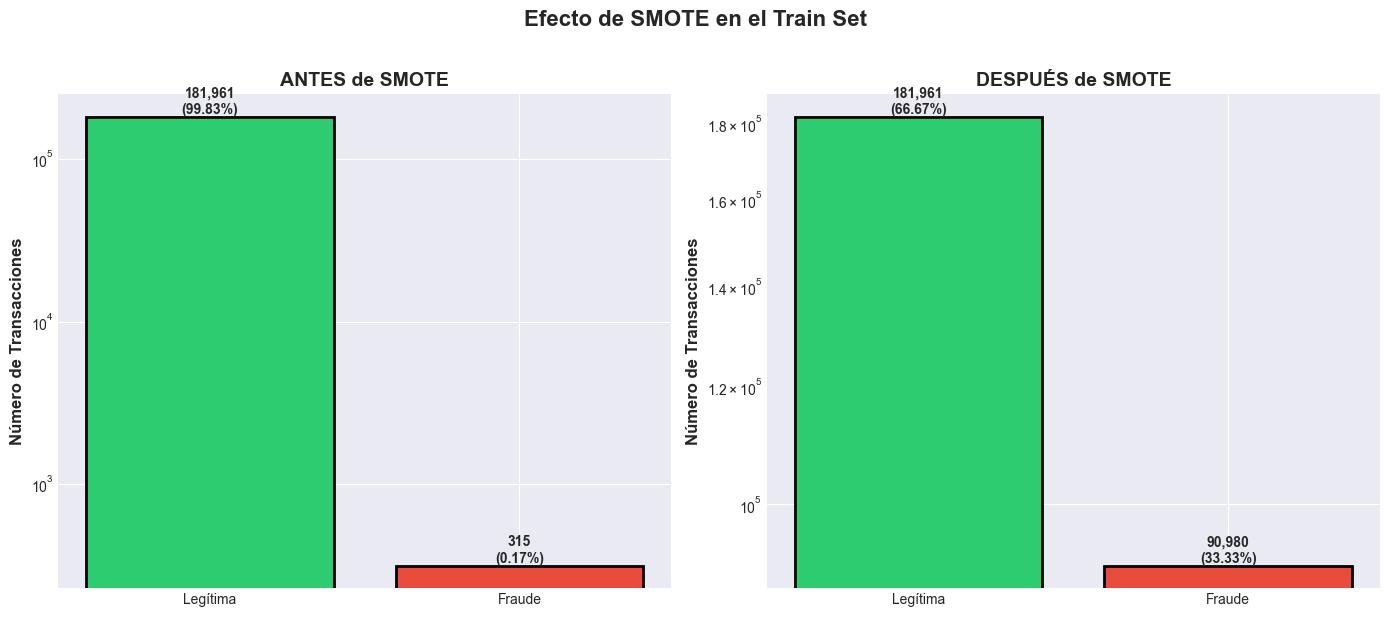

✅ Observa cómo SMOTE balancea el dataset sin duplicar exactamente


In [35]:
# Comparación visual: Antes vs Después de SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ANTES de SMOTE
axes[0].bar(['Legítima', 'Fraude'], train_counts.values,
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[0].set_ylabel('Número de Transacciones', fontsize=12, fontweight='bold')
axes[0].set_title('ANTES de SMOTE', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')  # Escala logarítmica

# Añadir etiquetas
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v, f'{v:,}\n({train_percentages.values[i]:.2f}%)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# DESPUÉS de SMOTE
axes[1].bar(['Legítima', 'Fraude'], balanced_counts.values,
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[1].set_ylabel('Número de Transacciones', fontsize=12, fontweight='bold')
axes[1].set_title('DESPUÉS de SMOTE', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')

# Añadir etiquetas
for i, v in enumerate(balanced_counts.values):
    axes[1].text(i, v, f'{v:,}\n({balanced_percentages.values[i]:.2f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Efecto de SMOTE en el Train Set', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Observa cómo SMOTE balancea el dataset sin duplicar exactamente")

In [36]:
# IMPORTANTE: Verificar que Validation y Test NO fueron modificados
print("=" * 60)
print("VERIFICACIÓN: VALIDATION Y TEST NO MODIFICADOS")
print("=" * 60)

print(f"\n✅ VALIDATION SET (sin SMOTE):")
val_counts = y_val.value_counts()
print(f"   • Legítimas: {val_counts[0]:,}")
print(f"   • Fraudes:   {val_counts[1]:,}")
print(f"   • Ratio: 1:{val_counts[0]/val_counts[1]:.0f}")

print(f"\n✅ TEST SET (sin SMOTE):")
test_counts = y_test.value_counts()
print(f"   • Legítimas: {test_counts[0]:,}")
print(f"   • Fraudes:   {test_counts[1]:,}")
print(f"   • Ratio: 1:{test_counts[0]/test_counts[1]:.0f}")

print(f"\n💡 NOTA IMPORTANTE:")
print(f"   Validation y Test mantienen el desbalanceo original")
print(f"   Esto es CORRECTO: queremos evaluar con datos reales del mundo")

VERIFICACIÓN: VALIDATION Y TEST NO MODIFICADOS

✅ VALIDATION SET (sin SMOTE):
   • Legítimas: 45,490
   • Fraudes:   79
   • Ratio: 1:576

✅ TEST SET (sin SMOTE):
   • Legítimas: 56,864
   • Fraudes:   98
   • Ratio: 1:580

💡 NOTA IMPORTANTE:
   Validation y Test mantienen el desbalanceo original
   Esto es CORRECTO: queremos evaluar con datos reales del mundo


In [37]:
# Guardar todos los conjuntos de datos procesados
print("=" * 60)
print("GUARDANDO DATOS PROCESADOS")
print("=" * 60)

# Crear diccionario con todos los conjuntos
datasets = {
    'X_train_balanced.csv': X_train_balanced,
    'y_train_balanced.csv': pd.DataFrame(y_train_balanced, columns=['Class']),
    'X_val.csv': X_val,
    'y_val.csv': pd.DataFrame(y_val),
    'X_test.csv': X_test,
    'y_test.csv': pd.DataFrame(y_test),
    # También guardamos train original (sin SMOTE) por si acaso
    'X_train_original.csv': X_train,
    'y_train_original.csv': pd.DataFrame(y_train)
}

# Guardar cada conjunto
for filename, data in datasets.items():
    filepath = PROCESSED_DATA_PATH / filename
    data.to_csv(filepath, index=False)
    print(f"   ✅ Guardado: {filename}")

print(f"\n📁 Todos los datos guardados en: {PROCESSED_DATA_PATH}")

# También guardar el scaler (lo necesitaremos en producción)
import joblib
scaler_path = PROCESSED_DATA_PATH / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"\n💾 Scaler guardado: {scaler_path}")
print(f"   (Necesario para escalar nuevas transacciones en producción)")

GUARDANDO DATOS PROCESADOS
   ✅ Guardado: X_train_balanced.csv
   ✅ Guardado: y_train_balanced.csv
   ✅ Guardado: X_val.csv
   ✅ Guardado: y_val.csv
   ✅ Guardado: X_test.csv
   ✅ Guardado: y_test.csv
   ✅ Guardado: X_train_original.csv
   ✅ Guardado: y_train_original.csv

📁 Todos los datos guardados en: c:\dev\repos-deep-learning\fraude-detection\data\processed

💾 Scaler guardado: c:\dev\repos-deep-learning\fraude-detection\data\processed\scaler.pkl
   (Necesario para escalar nuevas transacciones en producción)


## 🎉 RESUMEN DEL PREPROCESAMIENTO

### ✅ Lo que hemos logrado:

#### 1️⃣ **Escalado de Features**
- Aplicamos `StandardScaler` a `Time` y `Amount`
- Ahora todas las variables están en escalas similares
- Media ≈ 0, Desviación Estándar ≈ 1

#### 2️⃣ **División de Datos**
- **Train**: 64% del dataset (~182,000 transacciones)
- **Validation**: 16% del dataset (~45,000 transacciones)
- **Test**: 20% del dataset (~57,000 transacciones)
- Usamos **estratificación** para mantener proporciones

#### 3️⃣ **Balanceo con SMOTE**
- Aplicado SOLO en Train
- Ratio cambió de 1:576 a 1:2
- Generamos ~90,000 fraudes sintéticos
- Val y Test mantienen desbalanceo original ✅

#### 4️⃣ **Guardado de Datos**
- Todos los conjuntos guardados en `/data/processed/`
- Scaler guardado para uso en producción

---

### 📊 Datos Listos para Entrenamiento

Ahora tenemos:

✅ X_train_balanced: (182,276 × 30) - CON SMOTE
✅ y_train_balanced: (182,276,)
✅ X_val: (45,569 × 30) - SIN SMOTE
✅ y_val: (45,569,)
✅ X_test: (56,962 × 30) - SIN SMOTE
✅ y_test: (56,962,)

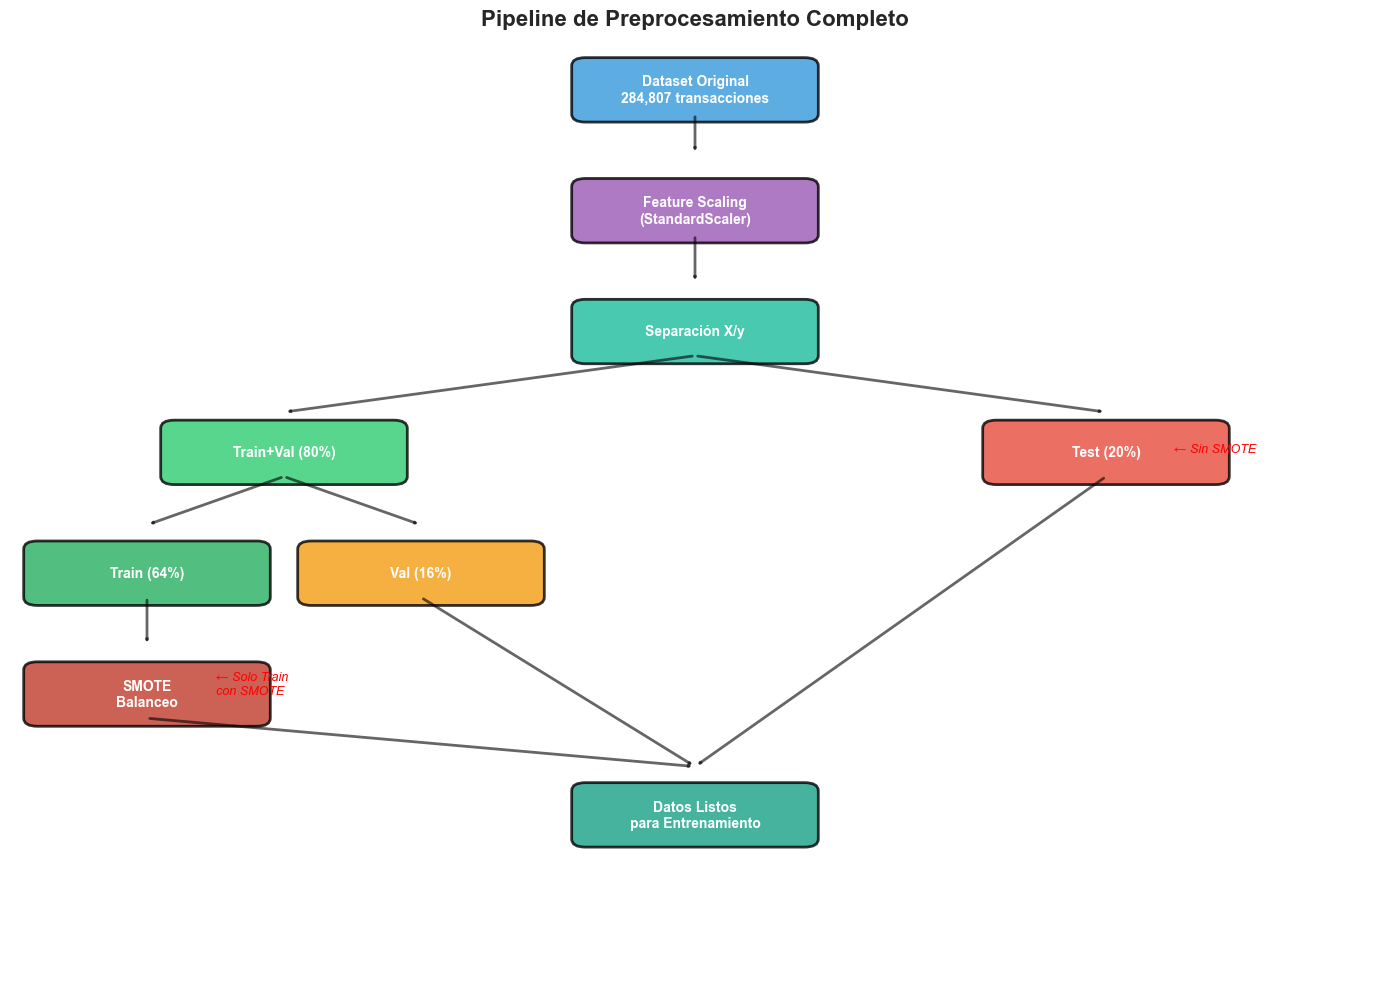

✅ Pipeline de preprocesamiento completado


In [38]:
# Diagrama visual del pipeline de preprocesamiento
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# Definir posiciones de los bloques
steps = [
    (5, 11, "Dataset Original\n284,807 transacciones", '#3498db'),
    (5, 9.5, "Feature Scaling\n(StandardScaler)", '#9b59b6'),
    (5, 8, "Separación X/y", '#1abc9c'),
    (2, 6.5, "Train+Val (80%)", '#2ecc71'),
    (8, 6.5, "Test (20%)", '#e74c3c'),
    (1, 5, "Train (64%)", '#27ae60'),
    (3, 5, "Val (16%)", '#f39c12'),
    (1, 3.5, "SMOTE\nBalanceo", '#c0392b'),
    (5, 2, "Datos Listos\npara Entrenamiento", '#16a085'),
]

# Dibujar bloques
for x, y, text, color in steps:
    box = FancyBboxPatch(
        (x-0.8, y-0.3), 1.6, 0.6,
        boxstyle="round,pad=0.1",
        edgecolor='black',
        facecolor=color,
        linewidth=2,
        alpha=0.8
    )
    ax.add_patch(box)
    ax.text(x, y, text, ha='center', va='center',
            fontsize=10, fontweight='bold', color='white')

# Dibujar flechas
arrows = [
    (5, 10.7, 5, 10.2),  # Original → Scaling
    (5, 9.2, 5, 8.6),    # Scaling → Separación
    (5, 7.7, 2, 7.0),    # Separación → Train+Val
    (5, 7.7, 8, 7.0),    # Separación → Test
    (2, 6.2, 1, 5.6),    # Train+Val → Train
    (2, 6.2, 3, 5.6),    # Train+Val → Val
    (1, 4.7, 1, 4.1),    # Train → SMOTE
    (1, 3.2, 5, 2.6),    # SMOTE → Final
    (3, 4.7, 5, 2.6),    # Val → Final
    (8, 6.2, 5, 2.6),    # Test → Final
]

for x1, y1, x2, y2 in arrows:
    arrow = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle='->,head_width=0.4,head_length=0.8',
        color='black',
        linewidth=2,
        alpha=0.6
    )
    ax.add_patch(arrow)

# Título
ax.text(5, 11.8, 'Pipeline de Preprocesamiento Completo',
        ha='center', fontsize=16, fontweight='bold')

# Anotaciones
ax.text(8.5, 6.5, '← Sin SMOTE', fontsize=9, style='italic', color='red')
ax.text(1.5, 3.5, '← Solo Train\ncon SMOTE', fontsize=9, style='italic', color='red')

plt.tight_layout()
plt.show()

print("✅ Pipeline de preprocesamiento completado")